In [31]:
import os
import tarfile
import zipfile
import hashlib
import requests
import pandas as pd
import torch
from torch import nn
from torch.utils import data
import matplotlib.pyplot as plt

## 下载和缓存数据集

In [32]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [33]:
def download_dataset(name, cache_dir=None):
    """下载一个DATA_HUB中的文件,返回本地文件名"""
    assert name in DATA_HUB, f"{name} not in {DATA_HUB}"
    cache_dir = os.path.join('..', 'data') if cache_dir is None else cache_dir
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
            if sha1.hexdigest() == sha1_hash:
                return fname
    print(f"Downloading {name} from {url} to {fname}...")
    raw_data = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(raw_data.content)
    return fname


In [34]:
def download_dataset_and_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download_dataset(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    match ext:
        case '.zip':
            fp = zipfile.ZipFile(fname, 'r')
        case '.tar', '.gz':
            fp = tarfile.open(fname, 'r')
        case _:
            assert False, f'不支持的文件类型：{ext}'
    fp.extractall(path=base_dir)
    fp.close()
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all_datasets():
    """下载DATA_HUB中的所有数据集"""
    for name in DATA_HUB:
        download_dataset(name)
    

## Kaggle

## 访问和读取数据集

In [35]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce'
)
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90'
)

In [36]:
train_data = pd.read_csv(download_dataset('kaggle_house_train'))
test_data = pd.read_csv(download_dataset('kaggle_house_test'))

In [37]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [38]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [39]:
all_features = pd.concat((
    train_data.iloc[:, 1:-1],
    test_data.iloc[:, 1:]
))

## 数据预处理

In [40]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [41]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [42]:
n_train = train_data.shape[0]

train_features = torch.tensor(all_features[:n_train].values.astype('float'), dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values.astype('float'), dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.astype('float').reshape(-1, 1), 
    dtype=torch.float32
)
train_features.shape, train_labels.shape, test_features.shape

(torch.Size([1460, 331]), torch.Size([1460, 1]), torch.Size([1459, 331]))

## 训练

In [43]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    return nn.Sequential(nn.Linear(in_features, 1))

In [44]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [45]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

In [46]:
def train(net, train_features, train_labels, test_features, test_labels, 
            num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr = learning_rate,
        weight_decay = weight_decay
    )
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls
                

In [47]:
def get_kfold_data(k, i, x, y):
    assert k > 1
    fold_size = x.shape[0] // k
    x_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        x_part, y_part = x[idx, :], y[idx]
        if j == i:
            x_valid, y_valid = x_part, y_part
        elif x_train is None:
            x_train, y_train = x_part, y_part
        else:
            x_train = torch.cat([x_train, x_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return x_train, y_train, x_valid, y_valid

In [48]:
def set_axes(axes, xlabel, ylabel, xscale, yscale, xlim, ylim):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.grid()

def plot(xs, ys, xlabel, ylabel, xlim=None, ylim=None, xscale='linear', yscale='linear', legend=None, figsize=(6, 3)):
    plt.rcParams['figure.figsize'] =figsize
    set_axes(plt.gca(), xlabel, ylabel, xscale, yscale, xlim, ylim)
    try:
        len(xs[0])
    except:
        xs = [xs]*len(ys)
    for x, y in zip(xs, ys):
        plt.plot(x, y)
    plt.legend(legend if legend else [])

In [49]:
def kfold(k, x_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_lsum, valid_lsum = 0, 0
    for i in range(k):
        data = get_kfold_data(k, i, x_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_lsum += train_ls[-1]
        valid_lsum += valid_ls[-1]
        if i == 0:
            plot(range(1, num_epochs+1), [train_ls, valid_ls], 
                 xlabel='epoch', ylabel='log rmse', xlim=[1,num_epochs], 
                 legend=['train', 'valid'])
        print(f'折{i+1}, 训练log rmse {float(train_ls[-1]):f}, ' 
              f'验证log rmse {float(valid_ls[-1]):f}')
    return train_lsum / k, valid_lsum / k

折1, 训练log rmse 0.170424, 验证log rmse 0.157442
折2, 训练log rmse 0.162490, 验证log rmse 0.189909
折3, 训练log rmse 0.164197, 验证log rmse 0.168489
折4, 训练log rmse 0.167912, 验证log rmse 0.154781
折5, 训练log rmse 0.163599, 验证log rmse 0.182880
5-折验证, 平均训练log rmse 0.165724, 平均验证log rmse 0.170700


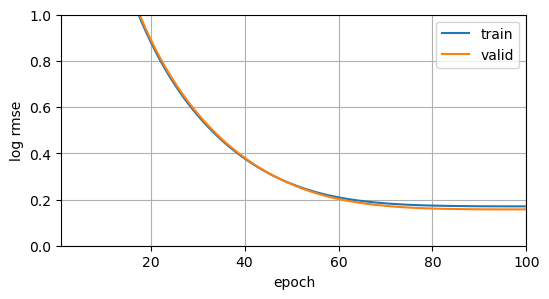

In [50]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = kfold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证, 平均训练log rmse {float(train_l):f}, ' 
      f'平均验证log rmse {float(valid_l):f}')

In [29]:
def train_and_pred(train_features, test_features, train_labels, test_data, 
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    plot(list(range(1, num_epochs+1)), [train_ls], xlabel='epoch', ylabel='log rmse', xlim=[1,num_epochs])
    print(f'训练log rmse: {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse: 0.162398


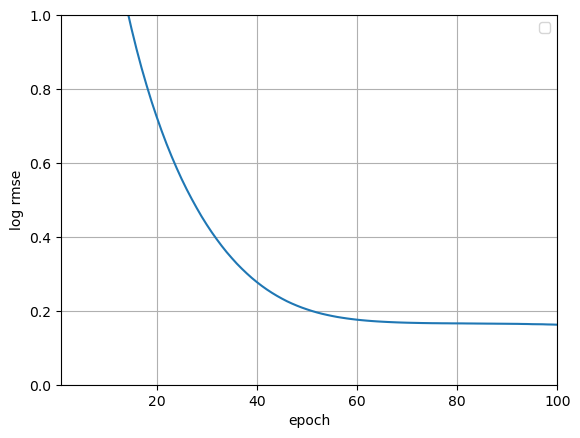

In [30]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

## Exercises

1. 把预测提交给Kaggle，它有多好？

2. 能通过直接最小化价格的对数来改进模型吗？如果试图预测价格的对数而不是价格，会发生什么？

3. 用平均值替换缺失值总是好主意吗？提示：能构造一个不随机丢失值的情况吗？

4. 通过$K$折交叉验证调整超参数，从而提高Kaggle的得分

5. 通过改进模型（例如，层、权重衰减和dropout）来提高分数

6. 如果我们没有像本节所做的那样标准化连续的数值特征，会发生什么?